In [9]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, hilbert

from kalman_experiments.kalman import Colored1DMatsudaKF, apply_kf
from kalman_experiments.models import SingleRhythmModel, ArNoise, collect, prepare_real_noise
from kalman_experiments.cfir import CFIRBandDetector, CFIRParams, apply_cfir
from kalman_experiments.complex import complex2mat, vec2complex
from kalman_experiments.metrics import plv, env_cor, crosscorr
from kalman_experiments.plots import plot_generated_signal, plot_kalman_vs_cfir, plot_crosscorrelations

# Simulated AR noise
Parameter A in the code below corresponds to A in Matsuda's model:
$$x_{k+1} = A e^{\frac{2 \pi i f}{sr}} x_k + \nu, \nu \sim N(0, \sigma ^ 2)$$

In [10]:
SRATE = 500
N_SAMP = 100_000

In [11]:
# Setup oscillatioins model and generate oscillatory signal
FREQ_GT = 10
A_GT = 0.99          # as in x_next = A*exp(2*pi*OSCILLATION_FREQ / sr)
SIGNAL_SIGMA_GT = 1     # std of the model-driving white noise in the Matsuda model

oscillation_model = SingleRhythmModel(freq=FREQ_GT, A=A_GT, s=SIGNAL_SIGMA_GT, sr=SRATE)
gt_states = collect(oscillation_model, N_SAMP)

In [12]:
# Setup simulated noise and measurements
NOISE_AR_ORDER = 1
ALPHA = 1
NOISE_SIGMA_GT = 5  # std of white noise driving the ar model for the colored noise

noise_model = ArNoise(x0=np.random.rand(NOISE_AR_ORDER), alpha=ALPHA, order=NOISE_AR_ORDER, s=NOISE_SIGMA_GT)
noise = collect(noise_model, N_SAMP)
meas = np.real(gt_states) + noise

<IPython.core.display.Javascript object>


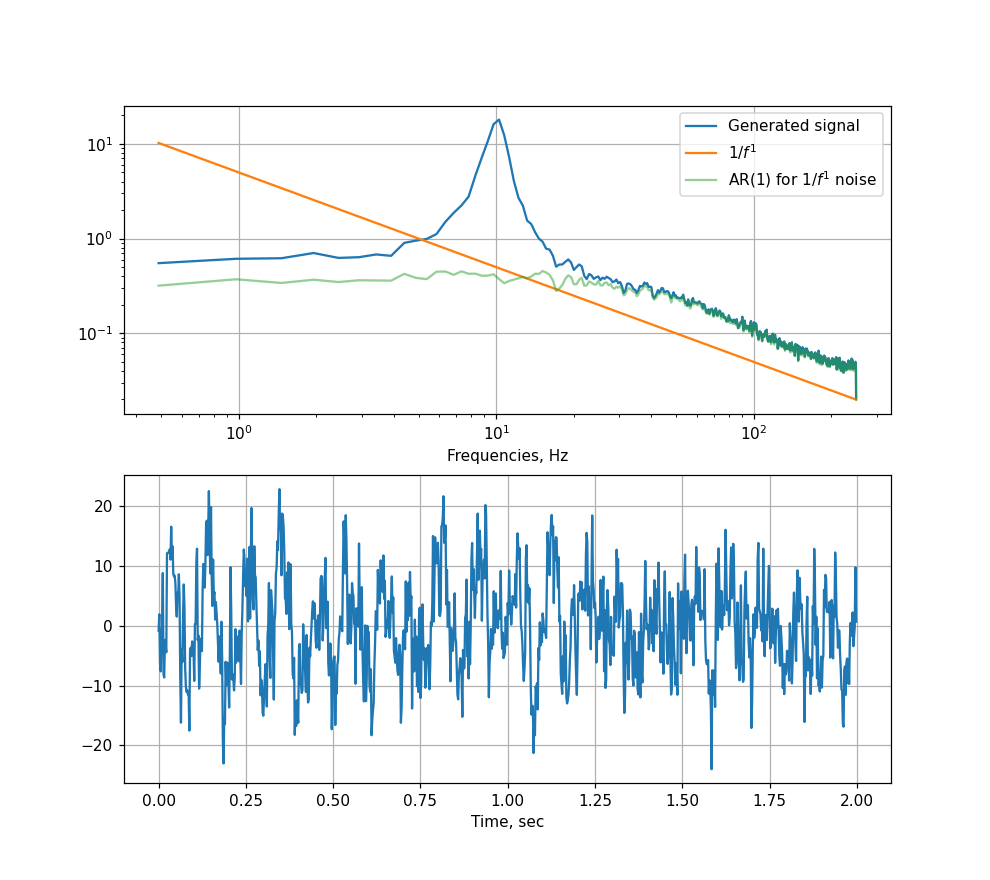

In [13]:
# Plot generated signal
legend = ["Generated signal", f"$1/f^{ {ALPHA} }$", f"AR({NOISE_AR_ORDER})" f" for $1/f^{ {ALPHA} }$ noise"]
plot_generated_signal(noise, meas, sr=SRATE, alpha=ALPHA, legend=legend, tmin=0, tmax=2)
plt.show()

In [26]:
# Setup filters

A_KF = A_GT
FREQ_KF = FREQ_GT
SIGNAL_SIGMA_KF = SIGNAL_SIGMA_GT
# PSI = 0
PSI = 0.5
# PSI = -0.5
NOISE_SIGMA_KF = NOISE_SIGMA_GT
DELAY = 0

kf = Colored1DMatsudaKF(A=A_KF, f=FREQ_KF, sr=SRATE, q_s=SIGNAL_SIGMA_KF, psi=PSI, r_s=NOISE_SIGMA_KF)
cfir = CFIRParams([8, 12], SRATE)

In [27]:
# Filter measurements with simulated noise

cfir_states = apply_cfir(cfir, meas, delay=DELAY)
kf_states = apply_kf(kf, meas, delay=DELAY)

KF total PLV =  0.79 CFIR total PLV =  0.67 KF envcor =  0.73 CFIR envcor =  0.56


<IPython.core.display.Javascript object>


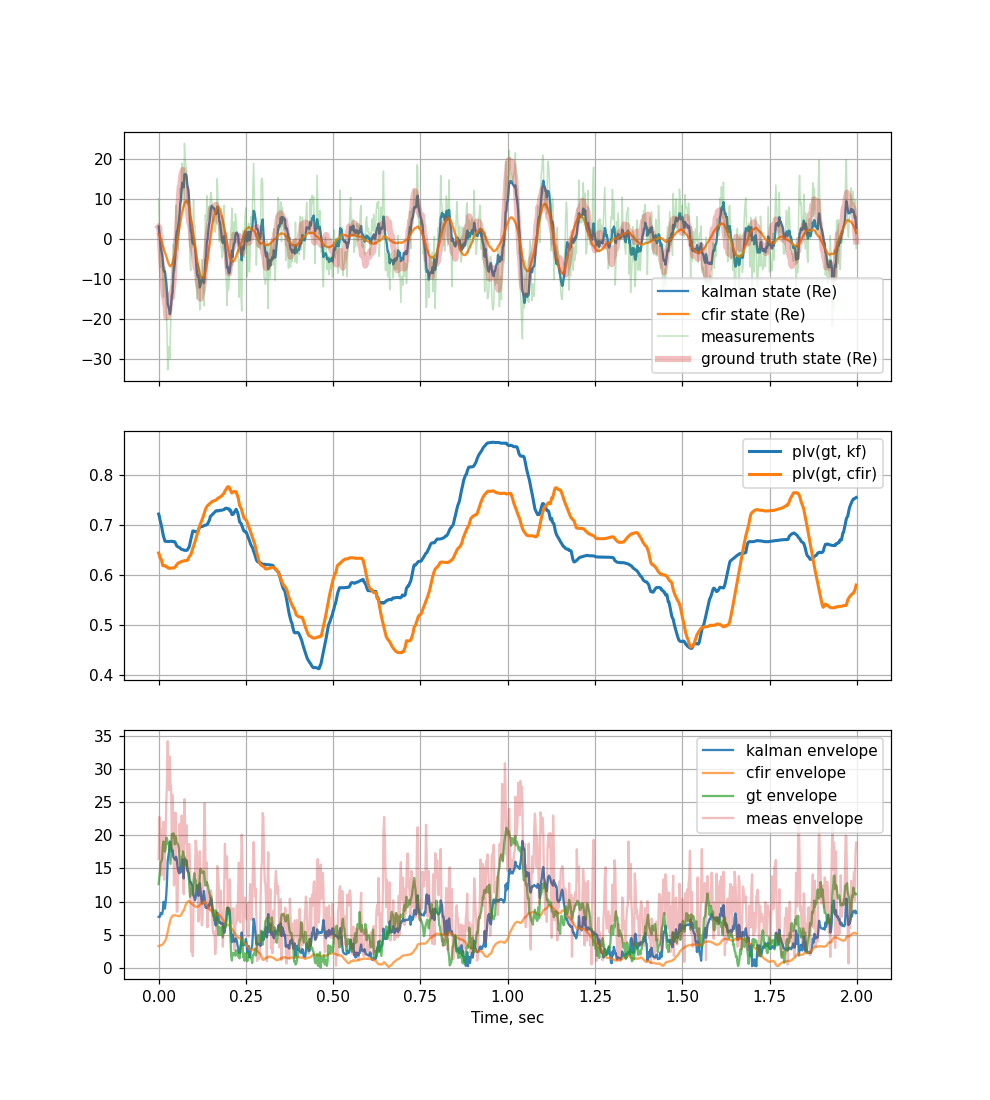

<IPython.core.display.Javascript object>


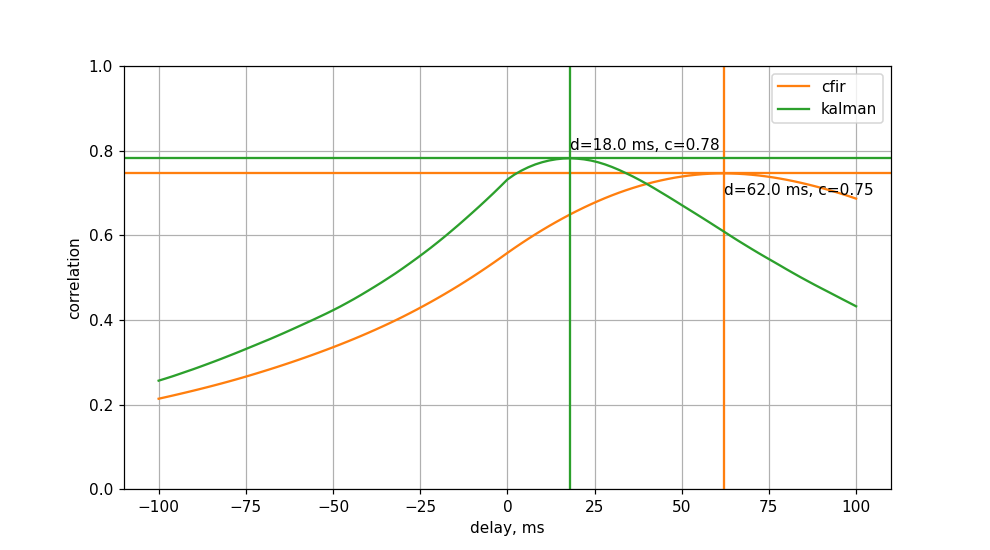

In [28]:
# Plot results for simulated noise

plv_win_kf, plv_tot_kf = plv(gt_states, kf_states, int(0.5 * SRATE))
plv_win_cfir, plv_tot_cfir = plv(gt_states, cfir_states, int(0.5 * SRATE))
envcor_kf = env_cor(gt_states.copy(), np.roll(kf_states.copy(), shift=-DELAY))
envcor_cfir = env_cor(gt_states.copy(), np.roll(cfir_states.copy(), shift=-DELAY))
print("KF total PLV = ", round(np.abs(plv_tot_kf), 2), "CFIR total PLV = ", round(np.abs(plv_tot_cfir), 2), end=" ")
print("KF envcor = ", round(envcor_kf, 2), "CFIR envcor = ", round(envcor_cfir, 2))

plot_kalman_vs_cfir(meas, gt_states, kf_states, cfir_states, plv_win_kf, plv_win_cfir, 1000, SRATE, DELAY)
plt.show()

# Plot envelope cross-correlations and delays

t, corrs_cfir = crosscorr(np.abs(gt_states), np.abs(cfir_states), SRATE, 50)
t, corrs_kf = crosscorr(np.abs(gt_states), np.abs(kf_states), SRATE, 50)
t_ms = t * 1000
plot_crosscorrelations(t_ms, corrs_cfir, corrs_kf)
plt.show()

# Real noise

<IPython.core.display.Javascript object>


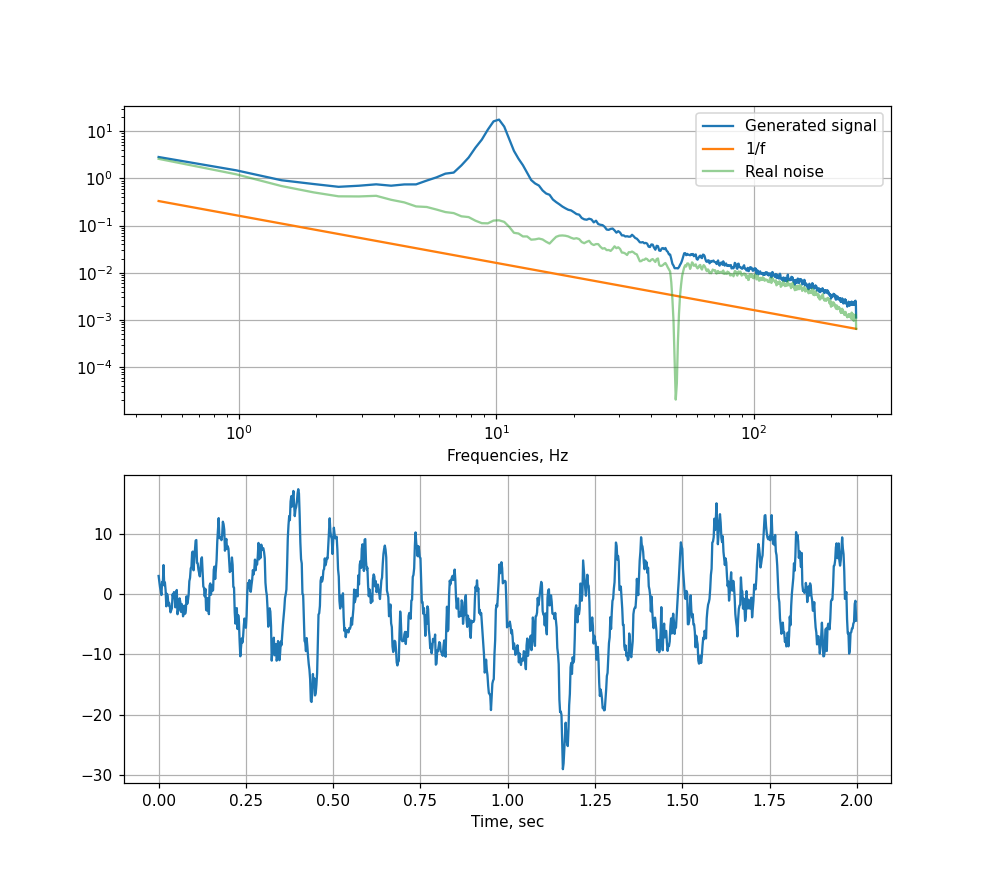

In [40]:
# Setup real noise and generate measurements

raw_path = "../data/ds004148/sub-01/ses-session2/eeg/sub-01_ses-session2_task-eyesopen_eeg.vhdr"
real_noise_model, srate = prepare_real_noise(raw_path=raw_path, s=NOISE_SIGMA_GT + 3)

noise = collect(real_noise_model, N_SAMP)
meas = np.real(gt_states) + noise

legend = ["Generated signal", f"1/f", "Real noise"]
plot_generated_signal(noise, meas, sr=int(srate), alpha=ALPHA, tmin=0, tmax=2, legend=legend)
plt.show()

In [41]:
cfir_states = cfir_adapter.apply(meas, delay=DELAY)
kf_states = kf_adapter.apply(meas, delay=DELAY)

<IPython.core.display.Javascript object>


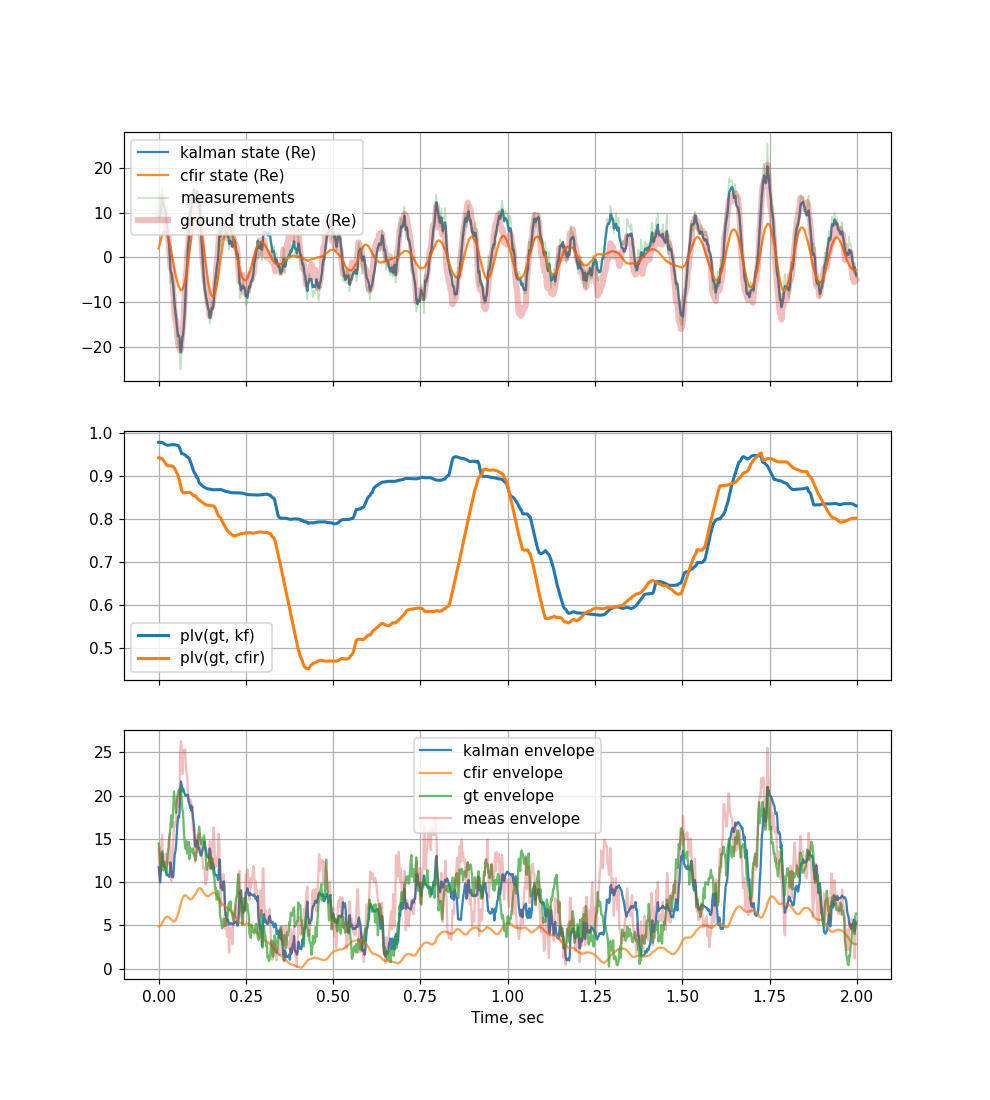

KF total PLV =  0.74 CFIR total PLV =  0.68 KF envcor =  0.63 CFIR envcor =  0.59


<IPython.core.display.Javascript object>


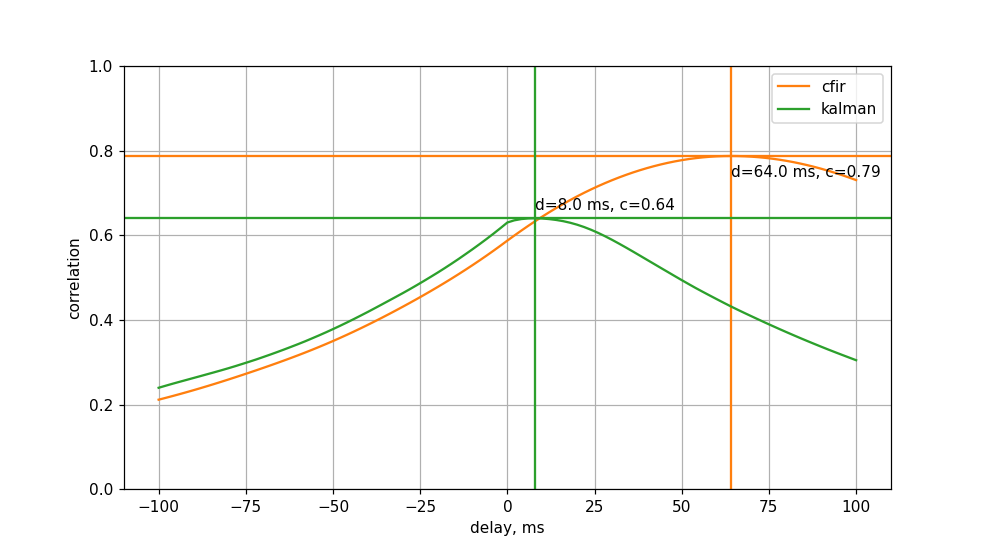

In [44]:
plv_win_kf, plv_tot_kf = plv(gt_states, kf_states, int(0.5 * SRATE))
plv_win_cfir, plv_tot_cfir = plv(gt_states, cfir_states, int(0.5 * SRATE))

plot_kalman_vs_cfir(meas, gt_states, kf_states, cfir_states, plv_win_kf, plv_win_cfir, 1000, srate, DELAY)
plt.show()

envcor_kf = env_cor(gt_states.copy(), np.roll(kf_states.copy(), shift=-DELAY))
envcor_cfir = env_cor(gt_states.copy(), np.roll(cfir_states.copy(), shift=-DELAY))
print("KF total PLV = ", round(np.abs(plv_tot_kf), 2), "CFIR total PLV = ", round(np.abs(plv_tot_cfir), 2), end=" ")
print("KF envcor = ", round(envcor_kf, 2), "CFIR envcor = ", round(envcor_cfir, 2))

# Plot envelope cross-correlations and delays

t, corrs_cfir = crosscorr(np.abs(gt_states), np.abs(cfir_states), srate, 50)
t, corrs_kf = crosscorr(np.abs(gt_states), np.abs(kf_states), srate, 50)
t_ms = t * 1000
plot_crosscorrelations(t_ms, corrs_cfir, corrs_kf)
plt.show()